<a href="https://colab.research.google.com/github/nisha-s10/Deep-Learning-Lab-AFI524/blob/main/Experiment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: RNN FROM SCRATCH (NUMPY)

### Step 1: Import NumPy

In [ ]:
import numpy as np

### Step 2: Create Dummy Vocabulary & Input

In [ ]:
vocab_size = 5
hidden_size = 10

# Dummy sequence (one-hot)
X = np.eye(vocab_size)[[0, 1, 2, 3]]

### Step 3: Initialize RNN Parameters

In [ ]:
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(vocab_size, hidden_size) * 0.01

bh = np.zeros((hidden_size, 1))
by = np.zeros((vocab_size, 1))

### Step 4: Forward Pass

In [ ]:
h = np.zeros((hidden_size, 1))

for t in range(len(X)):
    x = X[t].reshape(-1, 1)
    h = np.tanh(Wxh @ x + Whh @ h + bh)

y = Why @ h + by

print("Output shape:", y.shape)

Output shape: (5, 1)


# PART 2 – ONE-HOT ENCODING APPROACH

### Step 1: Load Dataset

In [ ]:
import pandas as pd
import re
from collections import Counter

df = pd.read_csv("poems-100.csv")

text = " ".join(df['text'].astype(str)).lower()
text = re.sub(r'[^a-zA-Z\s]', '', text)
text = re.sub(r'\s+', ' ', text)

### Step 2: Tokenization

In [ ]:
words = text.split()
word_counts = Counter(words)

# Limit vocab (important)
common_words = [w for w, _ in word_counts.most_common(5000)]
words = [w for w in words if w in common_words]

### Step 3: Create Vocabulary

In [ ]:
vocab = sorted(set(words))
vocab_size = len(vocab)

word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

### Step 4: Create Sequences

In [ ]:
seq_length = 5
inputs = []
targets = []

for i in range(len(words) - seq_length):
    seq = words[i:i+seq_length]
    target = words[i+seq_length]

    inputs.append([word2idx[w] for w in seq])
    targets.append(word2idx[target])

### Step 5: Convert to One-Hot

In [ ]:
import torch

X = []
for seq in inputs:
    onehot_seq = []
    for idx in seq:
        vec = np.zeros(vocab_size)
        vec[idx] = 1
        onehot_seq.append(vec)
    X.append(onehot_seq)
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).long()

### Step 6: Define RNN Model (PyTorch)

In [ ]:
import torch.nn as nn

class RNN_OneHot(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

### Step 7: Train Model

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import time

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_onehot = RNN_OneHot(vocab_size, 128, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_onehot.parameters(), lr=0.001)

losses_onehot = []
start = time.time()

for epoch in range(50):
    total_loss = 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        output = model_onehot(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses_onehot.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

end = time.time()
onehot_time = end - start
print("One-Hot Training Time:", onehot_time)

Epoch 1, Loss: 6.9969439857884455
Epoch 2, Loss: 6.492266868290148
Epoch 3, Loss: 6.287872758664583
Epoch 4, Loss: 6.058908700942993
Epoch 5, Loss: 5.831924267819053
Epoch 6, Loss: 5.583565262744301
Epoch 7, Loss: 5.329328431581196
Epoch 8, Loss: 5.054787432520013
Epoch 9, Loss: 4.778437290693584
Epoch 10, Loss: 4.498623880587126
Epoch 11, Loss: 4.2265713177229225
Epoch 12, Loss: 3.9576085090637205
Epoch 13, Loss: 3.697230355363143
Epoch 14, Loss: 3.4437971315885845
Epoch 15, Loss: 3.200748446113185
Epoch 16, Loss: 2.971323716013055
Epoch 17, Loss: 2.7543555811831824
Epoch 18, Loss: 2.548137816629912
Epoch 19, Loss: 2.359596059196874
Epoch 20, Loss: 2.1956875010540613
Epoch 21, Loss: 2.0290539779161154
Epoch 22, Loss: 1.890404022367377
Epoch 23, Loss: 1.7547569858400445
Epoch 24, Loss: 1.6337297063124807
Epoch 25, Loss: 1.5270341239477458
Epoch 26, Loss: 1.4182080877454657
Epoch 27, Loss: 1.3293126372914565
Epoch 28, Loss: 1.238357065539611
Epoch 29, Loss: 1.1529854106275659
Epoch 30, 

### Step 8: Generate Text

In [ ]:
def generate_onehot(model, start_word, length=20):
    model.eval()
    words_gen = [start_word]

    for _ in range(length):
        seq = words_gen[-seq_length:]
        seq_idx = [word2idx[w] for w in seq]

        seq_vec = []
        for idx in seq_idx:
            v = np.zeros(vocab_size)
            v[idx] = 1
            seq_vec.append(v)

        inp = torch.tensor([seq_vec], dtype=torch.float32).to(device)

        output = model(inp)
        next_word = torch.argmax(output).item()
        words_gen.append(idx2word[next_word])

    return " ".join(words_gen)

# PART 3 – TRAINABLE EMBEDDINGS APPROACH

### Step 1: Use Same Sequences (Indexed)

In [ ]:
X_emb = torch.tensor(inputs, dtype=torch.long)
Y_emb = torch.tensor(targets, dtype=torch.long)

### Step 2: Define Embedding Model

In [ ]:
class RNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

### Step 3: Train Embedding Model

In [ ]:
dataset_emb = TensorDataset(X_emb, Y_emb)
loader_emb = DataLoader(dataset_emb, batch_size=128, shuffle=True)

model_emb = RNN_Embedding(vocab_size, 100, 128).to(device)
optimizer = optim.Adam(model_emb.parameters(), lr=0.001)

losses_embedding = []
start = time.time()

for epoch in range(50):
    total_loss = 0

    for xb, yb in loader_emb:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        output = model_emb(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader_emb)
    losses_embedding.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

end = time.time()
embedding_time = end - start
print("Embedding Training Time:", embedding_time)

Epoch 1, Loss: 7.019674516979017
Epoch 2, Loss: 6.2331961656871595
Epoch 3, Loss: 5.913598808489348
Epoch 4, Loss: 5.614776109394274
Epoch 5, Loss: 5.311654424667358
Epoch 6, Loss: 5.013060522079468
Epoch 7, Loss: 4.709371403643959
Epoch 8, Loss: 4.410896106770164
Epoch 9, Loss: 4.107549351140072
Epoch 10, Loss: 3.8208334220083136
Epoch 11, Loss: 3.5434825232154443
Epoch 12, Loss: 3.278586184351068
Epoch 13, Loss: 3.034161469810887
Epoch 14, Loss: 2.8048879347349467
Epoch 15, Loss: 2.5854338997288755
Epoch 16, Loss: 2.3779742266002453
Epoch 17, Loss: 2.185065569375691
Epoch 18, Loss: 2.0066239934218557
Epoch 19, Loss: 1.8402332362375762
Epoch 20, Loss: 1.6833228889264558
Epoch 21, Loss: 1.5396808279188057
Epoch 22, Loss: 1.405998034226267
Epoch 23, Loss: 1.283058990930256
Epoch 24, Loss: 1.1689039227209592
Epoch 25, Loss: 1.0621531282600603
Epoch 26, Loss: 0.9651860186928197
Epoch 27, Loss: 0.8786689855550465
Epoch 28, Loss: 0.7950425493089777
Epoch 29, Loss: 0.7202581832283421
Epoch 3

### Step 4: Generate Text

In [ ]:
def generate_embedding(model, start_word, length=20):
    model.eval()
    words_gen = [start_word]

    for _ in range(length):
        seq = words_gen[-seq_length:]
        seq_idx = [word2idx[w] for w in seq]

        inp = torch.tensor([seq_idx], dtype=torch.long).to(device)
        output = model(inp)
        next_word = torch.argmax(output).item()
        words_gen.append(idx2word[next_word])

    return " ".join(words_gen)

# PART 4 – Comparison and Analysis

### Step 1 – Plot Loss Comparison

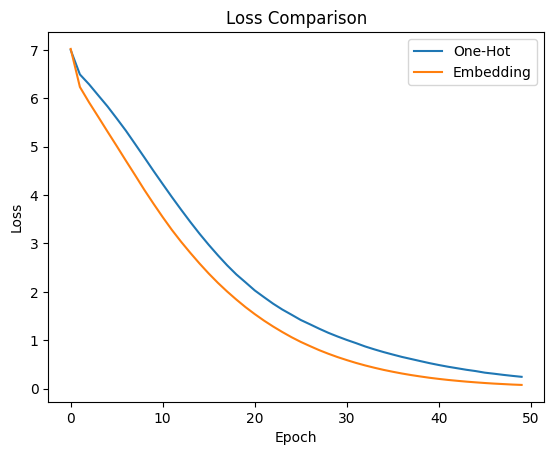

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_onehot, label="One-Hot")
plt.plot(losses_embedding, label="Embedding")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

### Step 2 – Compare Generated Text

In [ ]:
print("One-Hot Generated Text:\n")
print(generate_onehot(model_onehot, "love", 20))

print("\nEmbedding Generated Text:\n")
print(generate_embedding(model_emb, "love", 20))

One-Hot Generated Text:

love till i know gone the world of house care with day i stand a man grass you one to be

Embedding Generated Text:

love obey on their backs their white bellies bulge to the sun they do not ask who seizes fast to them


### Side-by-Side Comparison

In [ ]:
print("=== MODEL COMPARISON ===")
print(f"One-Hot Training Time: {onehot_time:.2f} seconds")
print(f"Embedding Training Time: {embedding_time:.2f} seconds")

print("\nFinal Loss Comparison:")
print(f"One-Hot Final Loss: {losses_onehot[-1]:.4f}")
print(f"Embedding Final Loss: {losses_embedding[-1]:.4f}")

=== MODEL COMPARISON ===
One-Hot Training Time: 356.68 seconds
Embedding Training Time: 157.25 seconds

Final Loss Comparison:
One-Hot Final Loss: 0.2436
Embedding Final Loss: 0.0762


### One-Hot Encoding
#### ✅ Advantages

* Simple and easy to implement.
* No training required for word representation.
* Direct representation of vocabulary.
* Works well for very small datasets.

#### ❌ Disadvantages

* High dimensional vectors (size = vocabulary size).
* Very memory inefficient (sparse vectors).
* Slower training.
* Does not capture semantic similarity between words.
* Poor scalability for large vocabularies.

### Trainable Word Embeddings
#### ✅ Advantages

* Low-dimensional dense representation.
* Memory efficient.
* Faster training.
* Captures semantic relationships between words.
* Better text generation quality.
* Scales well to large vocabularies.

#### ❌ Disadvantages

* Requires additional training.
* Slightly more complex to implement.
* Needs more data to learn meaningful embeddings.